In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns


from utils import *

ModuleNotFoundError: No module named 'exceptions'

In [2]:
def add_feature(doc):

    def visit(word):

        if word.pos_ == 'AUX':
            if word.dep_ == 'aux':
                word._.feature = 'aux' # Syntactic auxiliary verb
            elif word.n_lefts > 0 and next(word.lefts).lemma_ == 'there':
                word._.feature = 'there be'
            elif word.n_rights > 0 and next(word.rights).dep_ != 'cc':
                word._.feature = 'copula'
            else:
                word._.feature = 'other aux'
        elif word.pos_ == 'VERB':
            if word.lemma_ == 'see' and word.n_lefts > 0 and next(word.lefts).text.upper() == 'I':
                word._.feature = 'i see'
            elif word.lemma_ != 'see' and word.n_lefts > 0 and next(word.lefts).text.upper() == 'I':
                word._.feature = 'i ...'
            elif word.lemma_ == 'appear' and word.n_rights > 0 and next(word.rights).pos_ == 'AUX':
                word._.feature = 'appear to be'
            elif word.lemma_ == 'look' and word.n_rights > 0 and next(word.rights).pos_ == 'SCONJ':
                word._.feature = 'look like'
            elif word.dep_ == 'ccomp':
                word._.feature = 'verb'
            else:
                word._.feature = 'verb'
        elif word.pos_ == 'NOUN' or word.pos_ == 'NUM':
            try:
                anc = next(word.ancestors)
                if anc.pos_ == 'VERB' and word.dep_ == 'dobj':
                    if anc._.feature and anc._.feature == 'i see':
                        word._.feature = 'predicate'
                    else:
                        word._.feature = 'argument'
                elif anc.pos_ == 'ADP' and word.dep_ == 'pobj':
                    if anc.text.lower() != 'of':
                        try:
                            anc_anc = next(anc.ancestors)
                            if anc_anc.pos_ == 'AUX' and len([x for x in anc_anc.rights if x.pos_ == 'ADP']) == 1:
                                word._.feature = 'argument'
                            else:
                                word._.feature = 'adjunct'
                        except:
                            word._.feature = 'adjunct'
                    else:
                        try:
                            anc_anc = next(anc.ancestors)
                            if anc_anc._.feature:
                                word._.feature = anc_anc._.feature
                                anc_anc._.feature = '... of'
                        except:
                            pass
                elif anc.pos_ == 'AUX' and word.dep_ == 'attr' or word.dep_ == 'dobj':
                    word._.feature = 'predicate'
                elif anc.pos_ == 'SCONJ' and word.dep_ == 'pobj':
                    try:
                        anc_anc = next(anc.ancestors)
                        if anc_anc.pos_ == 'AUX' or anc_anc.lemma_ == 'look':
                            word._.feature = 'predicate'
                        else:
                            word._.feature = 'adjunct'
                    except:
                        pass
                elif anc._.feature and word.dep_ == 'conj':
                    if anc.pos_ != 'VERB':
                        word._.feature = anc._.feature + ' conj'
                    else:
                        try:
                            anc_anc = next(anc.ancestors)
                            if anc_anc._.feature and anc_anc.pos_ != 'VERB':
                                word._.feature = anc_anc._.feature + ' conj'
                        except:
                            pass
            except:
                pass
        elif word.pos_ == 'ADV' and word.dep_ == 'advmod':
            try:
                anc = next(word.ancestors)
                if anc.pos_ not in ('ADV', 'AUX'):
                    word._.feature = 'adv adjunct'
                elif anc.pos_ == 'AUX':
                    n_nouns = 0
                    n_advs = 0
                    for right in anc.rights:
                        if right.pos_ == 'NOUN':
                            n_nouns += 1
                        elif right.pos_ == 'ADV':
                            n_advs += 1
                    if n_nouns > 0:
                        word._.feature = 'adv adjunct'
                    elif n_advs == 1:
                        word._.feature = 'predicate'
            except:
                pass
        elif word.pos_ == 'ADJ' and word.dep_ == 'acomp':
            word._.feature = 'predicate'

        if word._.feature == 'adjunct':
            try:
                anc = next(word.ancestors)
                if anc.lemma_ == 'into':
                    try:
                        anc_anc = next(anc.ancestors)
                        if anc_anc.lemma_ == 'pour':
                            word._.feature = 'argument'
                    except:
                        pass
            except:
                pass

        for child in word.children:
            visit(child)


    for sent in doc.sents:
        if len(sent) > 0:
            visit(sent.root)

In [3]:
# data = read_data(PATH='./examples')
# data = data.drop(208792)
# data = process_data(data)
# data.head()

In [3]:
data = read_docx(PATH='./Transcripts')
data = process_data(data, process_text=True, apply_nlp=False, text_with_features=False, to_aggregate=False)
data.head(2)

,,variant,raw text,text,processed text
pidn,visit,,,,
588,0,svPPA_L,"Well there’s a man and a lady, and the there’s...","Well there's a man and a lady, and the there's...","Well there's a man and a lady, and the there's..."
1279,0,bvFTD,Well I see some people out beside a lake with ...,Well I see some people out beside a lake with ...,Well I see some people out beside a lake with ...


In [5]:
# nfvppa_type = pd.read_csv('nfvppa_type.csv', index_col=0)
# data.update(nfvppa_type.loc[~nfvppa_type['type'].isnull(), 'type'].rename('variant'))

In [4]:
both_processed_manual = pd.read_csv('both_processed_manual.csv', index_col=0)
data.update(both_processed_manual)

In [5]:
aoa_processed_manual = pd.read_csv('aoa_processed_manual.csv', index_col=0)
data.update(aoa_processed_manual)

In [6]:
data = process_data(data, process_text=False, apply_nlp=True, text_with_features=True, to_aggregate=True)

In [7]:
get_text_with_pos(data.loc[(1279, 0), 'doc'], pos='both')

"Well<INTJ UH> I<PRON PRP> see<VERB VBP> some<DET DT> people<NOUN NNS> out<ADP RP> beside<ADP IN> a<DET DT> lake<NOUN NN> with<ADP IN> their<PRON PRP$> cabin<NOUN NN> and<CCONJ CC> their<PRON PRP$> car<NOUN NN> and<CCONJ CC> there<PRON EX> 's<VERB VBZ> a<DET DT> sailboat<NOUN NN> down<ADP RP> in<ADP IN> the<DET DT> water<NOUN NN>. And<CCONJ CC> I<PRON PRP> see<VERB VBP> a<DET DT> boy<NOUN NN> flying<VERB VBG> his<PRON PRP$> kite<NOUN NN>. And<CCONJ CC> somebody<PRON NN> out<ADP RP> on<ADP IN> the<DET DT> dock<NOUN NN> fishing<NOUN NN>. And<CCONJ CC> I<PRON PRP> see<VERB VBP> the<DET DT> boy<NOUN NN> out<ADV RB> there<ADV RB> surfing<VERB VBG>. And<CCONJ CC> a<DET DT> dog<NOUN NN>. And<CCONJ CC> then<ADV RB> back<ADV RB>, with<ADP IN> a<DET DT> boy<NOUN NN> and<CCONJ CC> a<DET DT> girl<NOUN NN>, and<CCONJ CC> the<DET DT> girl<NOUN NN> is<AUX VBZ> pouring<VERB VBG> some<DET DT> drink<NOUN NN> sitting<VERB VBG> on<ADP IN> a<DET DT> carpet<NOUN NN>. And<CCONJ CC> they<PRON PRP> have<VERB V

In [8]:
data.loc[:, 'text with pos'] = data.loc[:, 'doc'].apply(get_text_with_pos, pos='both')

In [11]:
# data.loc[:, ['variant', 'text with features']].to_excel('text_with_features_all.xlsx')

In [11]:
data.loc[1619, 'text with pos'].loc[0]

"It<PRON PRP> appears<VERB VBZ> to<PART TO> be<VERB VB> a<DET DT> scene<NOUN NN> that<DET WDT> has<VERB VBZ> both<CCONJ CC> a<DET DT> house<NOUN NN> that<DET WDT> someone<PRON NN> might<AUX MD> live<VERB VB> in<ADP IN> and<CCONJ CC> a<DET DT> lake<NOUN NN>. And<CCONJ CC> On<ADP IN> the<DET DT> lake<NOUN NN> is<AUX VBZ> a<DET DT> sailboat<NOUN NN> with<ADP IN> people<NOUN NNS> sailing<VERB VBG>, there<PRON EX> 's<AUX VBZ> also<ADV RB> appears<VERB VBZ> to<PART TO> be<VERB VB> someone<PRON NN> sitting<VERB VBG> on<ADP IN> a<DET DT> pier<NOUN NN> fishing<NOUN NN>. There<PRON EX> 's<AUX VBZ> There<PRON EX> also<ADV RB> appears<VERB VBZ> to<PART TO> be<VERB VB> a<DET DT> child<NOUN NN> playing<VERB VBG> in<ADP IN> sand<NOUN NN>. They<PRON PRP> they<PRON PRP> are<AUX VBP> in<ADP IN> the<DET DT> water<NOUN NN> but<CCONJ CC> there<PRON EX> is<VERB VBZ> a<DET DT> sand<NOUN NN> bucket<NOUN NN> and<CCONJ CC> a<DET DT> shovel<NOUN NN>. There<PRON EX> 's<AUX VBZ> a<DET DT> young<ADJ JJ>. maybe<ADV 

In [19]:
svg_29231 = spacy.displacy.render(list(data.loc[29231, 'doc'].iloc[0].sents)[0], jupyter=False)
with open('rendered_29231.svg', 'w') as f:
    f.write(svg_29231)

In [24]:
svg_28437 = spacy.displacy.render(list(data.loc[28437, 'doc'].iloc[0].sents)[0][:-1], jupyter=False)
with open('rendered_28437.svg', 'w') as f:
    f.write(svg_28437)

In [21]:
svg_1619 = spacy.displacy.render(list(data.loc[1619, 'doc'].iloc[0].sents)[7], jupyter=False)
with open('rendered_1619_7.svg', 'w') as f:
    f.write(svg_1619)

In [45]:
svg_1653 = spacy.displacy.render(list(data.loc[1653, 'doc'].iloc[0].sents)[24], jupyter=False)
with open('rendered_1653.svg', 'w') as f:
    f.write(svg_1653)

In [44]:
spacy.displacy.render(list(data.loc[1653, 'doc'].iloc[0].sents)[24], style='dep')

In [35]:
print(list(enumerate("""Well<INTJ UH> the<DET DT> first<ADJ JJ> thing<NOUN NN> I<PRON PRP> see<VERB VBP> is<AUX VBZ> a<DET DT> dog<NOUN NN>. 
The<DET DT> dog<NOUN NN> looks<VERB VBZ> like<SCONJ IN> my<DET PRP$> dog<NOUN NN>. 
seeing<VERB VBG> him<PRON PRP> flying<VERB VBG> this<DET DT>. 
I<PRON PRP> can<VERB MD> not<PART RB> remember<VERB VB> what<PRON WP> the<DET DT> name<NOUN NN> of<ADP IN> this<DET DT> is<AUX VBZ>. 
It<PRON PRP> 's<AUX VBZ> up<ADV RB> in<ADP IN> the<DET DT> air<NOUN NN> there<ADV RB>. 
There<PRON EX> 's<AUX VBZ> a<DET DT> flag<NOUN NN> and<CCONJ CC>. 
Here<ADV RB> 's<AUX VBZ> a<DET DT> boat<NOUN NN>. 
Here<ADV RB> 's<AUX VBZ> someone<PRON NN> fishing<VERB VBG>. 
Of<ADV RB> course<ADV RB>, here<ADV RB> 's<AUX VBZ> a<DET DT> house<NOUN NN>. 
And<CCONJ CC> a<DET DT> variety<NOUN NN> of<ADP IN> trees<NOUN NNS> around<ADP IN> the<DET DT> house<NOUN NN>. 
And<CCONJ CC> a<DET DT> car<NOUN NN> parked<VERB VBN> in<ADP IN> front<NOUN NN> of<ADP IN> the<DET DT> garage<NOUN NN>. 
And<CCONJ CC> here<ADV RB> 's<AUX VBZ> a<DET DT> man<NOUN NN> and<CCONJ CC> woman<NOUN NN> eating<VERB VBG> sitting<VERB VBG> on<ADP IN> the<DET DT> ground<NOUN NN>. 
They<PRON PRP> have<AUX VBP> a<DET DT> radio<NOUN NN> beside<ADP IN> the<DET DT> woman<NOUN NN>. 
They<PRON PRP> have<AUX VBP> food<NOUN NN> beside<ADP IN> the<DET DT> man<NOUN NN>. 
He<PRON PRP> 's<AUX VBZ> reading<VERB VBG> a<DET DT> book<NOUN NN> while<SCONJ IN> she<PRON PRP> is<AUX VBZ> pouring<VERB VBG> some<DET DT> liquid<NOUN NN>. 
And<CCONJ CC> over<ADP IN> the<DET DT> far<ADV RB> right<ADJ JJ> side<NOUN NN> looks<VERB VBZ> like<SCONJ IN> a<DET DT> small<ADJ JJ> boy<NOUN NN> playing<VERB VBG> in<ADP IN> the<DET DT> water<NOUN NN>. 
And<CCONJ CC> a<DET DT> couple<NOUN NN> of<ADP IN> toys<NOUN NNS> of<ADP IN> his<DET PRP$> still<ADV RB> in<ADP IN> the<DET DT>. 
Now<ADV RB>, I<PRON PRP> forget<VERB VBP> what<PRON WP> the<DET DT> front<NOUN NN> of<ADP IN> this<DET DT> is<AUX VBZ> called<VERB VBN>. 
But<CCONJ CC> I<PRON PRP> 'm<AUX VBP> gon<VERB VBG> na<PART TO> say<VERB VB> it<PRON PRP> 's<AUX VBZ> in<ADP IN> the<DET DT> sand<NOUN NN>. 
And<CCONJ CC> I<PRON PRP> think<VERB VBP> that<SCONJ IN> basically<ADV RB> describes<VERB VBZ> everything<PRON NN> that<DET WDT> 's<AUX VBZ> there<ADV RB>.""".split('\n'))))

[(0, 'Well<INTJ UH> the<DET DT> first<ADJ JJ> thing<NOUN NN> I<PRON PRP> see<VERB VBP> is<AUX VBZ> a<DET DT> dog<NOUN NN>. '), (1, 'The<DET DT> dog<NOUN NN> looks<VERB VBZ> like<SCONJ IN> my<DET PRP$> dog<NOUN NN>. '), (2, 'seeing<VERB VBG> him<PRON PRP> flying<VERB VBG> this<DET DT>. '), (3, 'I<PRON PRP> can<VERB MD> not<PART RB> remember<VERB VB> what<PRON WP> the<DET DT> name<NOUN NN> of<ADP IN> this<DET DT> is<AUX VBZ>. '), (4, "It<PRON PRP> 's<AUX VBZ> up<ADV RB> in<ADP IN> the<DET DT> air<NOUN NN> there<ADV RB>. "), (5, "There<PRON EX> 's<AUX VBZ> a<DET DT> flag<NOUN NN> and<CCONJ CC>. "), (6, "Here<ADV RB> 's<AUX VBZ> a<DET DT> boat<NOUN NN>. "), (7, "Here<ADV RB> 's<AUX VBZ> someone<PRON NN> fishing<VERB VBG>. "), (8, "Of<ADV RB> course<ADV RB>, here<ADV RB> 's<AUX VBZ> a<DET DT> house<NOUN NN>. "), (9, 'And<CCONJ CC> a<DET DT> variety<NOUN NN> of<ADP IN> trees<NOUN NNS> around<ADP IN> the<DET DT> house<NOUN NN>. '), (10, 'And<CCONJ CC> a<DET DT> car<NOUN NN> parked<VERB VBN> i

In [29]:
spacy.displacy.render(nlp('He came while I was there.'))

In [12]:
# data.loc[:, ['variant', 'text with pos']].to_excel('text_with_pos_all.xlsx')

In [13]:
doc = nlp('I don\'t know she pours wine into a cup.')
add_feature(doc)
print(get_text_with_features(doc))
# spacy.displacy.render(doc)

I do<aux> n't know<i ...> she pours<verb> wine<argument> into a cup<argument>.


In [14]:
doc = data.loc[(25694, 0), 'doc']
add_feature(doc)
print((list(doc.sents)[4]))
# spacy.displacy.render(list(doc.sents)[4])

there, it appears to be a woodsy setting.


In [15]:
# print(data.loc[8438, 'processed text'])

In [16]:
# list(data.loc[8438, 'doc'].sents)[2]

In [17]:
# spacy.displacy.render(data.loc[8438, 'doc'])

In [18]:
# spacy.displacy.render(doc)

In [19]:
# data.loc[:, ['variant']].join(data.loc[:, 'ADJ':'verb'].astype(int)).to_excel('data.xlsx')

In [20]:
nouns_verbs = pd.DataFrame(columns=['pidn', 'noun', 'verb']).set_index('pidn')
nouns_verbs.loc[:, 'noun'] = data.loc[:, 'doc'].apply(lambda x: set([y.lemma_ for y in x if y.pos_ == 'NOUN']))
nouns_verbs.loc[:, 'verb'] = data.loc[:, 'doc'].apply(lambda x: set([y.lemma_ for y in x if y.pos_ == 'VERB']))
# nouns_verbs.to_excel('nouns_verbs.xlsx')

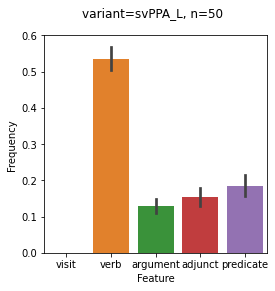

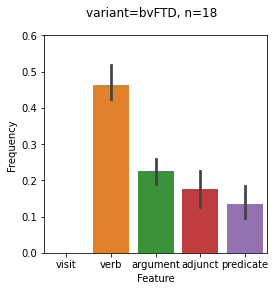

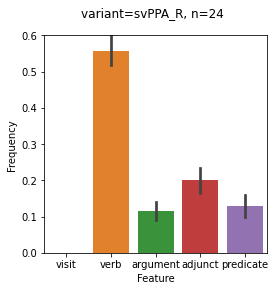

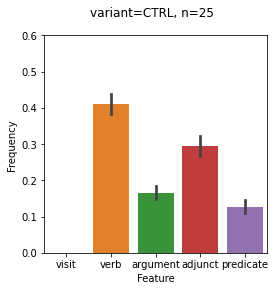

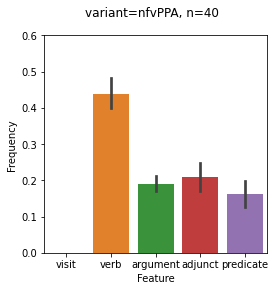

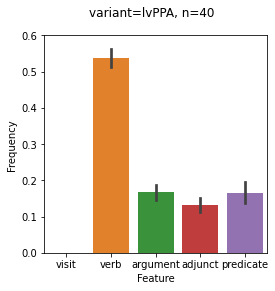

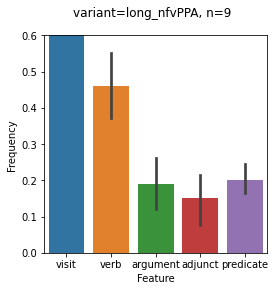

In [21]:
for variant in data['variant'].unique():
    fig = graph_features(data, variant, features=['verb', 'argument', 'adjunct', 'predicate'], sentiment=False);
#     fig.savefig('figures/verb_argument_adjunct/{}.png'.format(variant))

<AxesSubplot:xlabel='variant', ylabel='arg_adj_ratio'>

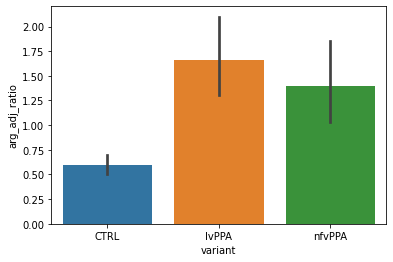

In [22]:
data.loc[:, 'arg_adj_ratio'] = data.loc[:, 'argument'] / data.loc[:, 'adjunct'].apply(lambda x: x if x > 0 else 1)
sns.barplot(y='arg_adj_ratio', x='variant', order=['CTRL', 'lvPPA', 'nfvPPA'], data=data)
# plt.savefig('figures/arg_adj_ratio.png')

In [23]:
# data.loc[:, ['variant']].join(data.loc[:, 'sentiment':'arg_adj_ratio']).to_excel('data.xlsx')

In [24]:
# data.loc[data['variant'] == 'nfvPPA', 'text with features'].to_excel('nfvppa_text_with_features.xlsx')

In [26]:
# data.loc[:, ['words', 'stop words', 'sentences']] = data.loc[:, 'doc'].apply(lambda doc: pd.Series((len(doc), sum([token.is_stop for token in doc]), len(list(doc.sents))), index=('words', 'stop words', 'sentences')))

In [ ]:
# data.loc[:, ['variant']].join(data.loc[:, 'ADJ':'VERB']).to_excel('aggregate_pos_all.xlsx')

In [ ]:
# data.loc[:, ['variant']].join(data.loc[:, 'ADJ':]).drop(columns='text with pos').to_excel('aggregate_all.xlsx')

In [ ]:
morphosyntactic_features = ['CCONJ CC', 'DET PRP$', 'DET WP$',
                            'PRON NN', 'PRON PRP', 'PRON WP', 'PROPN NNP', 'SCONJ IN',
                            'VERB MD', 'VERB VB', 'VERB VBD', 'VERB VBG', 'VERB VBN',
                            'VERB VBP', 'VERB VBZ']

In [ ]:
data.loc[:, 'non-stop words'] = data['words'] - data['stop words']

In [ ]:
# data.loc[:, ['variant', 'non-stop words'] + morphosyntactic_features].to_excel('morphosyntax.xlsx')

In [31]:
print(data.loc[(15069, 0), 'processed text'])

I see a man flying a kite.
I see a sailboat in the ocean.
I see a child playing in the sand.
I see a dog watching the boy flying a kite.
I see some people having a picnic.
I see a radio on the blanket, and a picnic basket there.
I see a girl pouring a a glass of something to drink.
The boy is reading a book. He wears glasses.
I see a tree growing in front of the window.
I see a car in the driveway.
Apparently, it's a windy day.
I can see the flag flying, and the kite is flying too.
The sailboat is on the water.
I see a shovel and a sand bucket in the sand.
I think the boy is that was playing in the sand is now in the water.
I see a dock there also.
I see something hanging on the end of the dock.
I don't know if it was a bucket or is something else.
I see a radio on the blanket with the people that are having a picnic.
The girl is wearing shorts and shirt.
The man is wearing long pants and a shirt. The man on the blanket.
The man who is flying a kite wearing long pants also.
The child i